In [ ]:
# Copyright (c) 2026 PredxBio Inc.

# This code is provided solely for the purpose of peer review in connection
# with the submission of a manuscript to a scientific journal.

# All rights reserved. This code may not be copied, modified, distributed,
# or made publicly available, in whole or in part, without the express
# written permission of the author.

In [ ]:
%load_ext autoreload
%autoreload 2

import boto3
from copy import copy
import re
import joypy
import random
import skimage
import pandas as pd
import numpy as np
from io import StringIO, BytesIO
import matplotlib
from matplotlib.lines import Line2D
from matplotlib import rc, colors
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from mne_connectivity.viz import plot_connectivity_circle
from multiprocessing import SimpleQueue
from multiprocessing.pool import Pool
from scipy.spatial import distance
from scipy.stats import norm, zscore, ttest_ind, permutation_test, rankdata, kendalltau, iqr, \
                        pearsonr, kstest, wilcoxon, spearmanr
import seaborn as sns
from typing import Any
import os
import sys
import itertools
from itertools import chain, zip_longest, combinations
from IPython.display import display, clear_output
import warnings

sys.path.append("./src/")
sys.path.append("./Modules/")
sys.path.append("./Modules/Cellgraph/src")

from recursive_celltyping import louvain_cluster, cluster_partition, predict_cluster, \
                                 splittingBMs, recursive_cluster, rna_deconv, \
                                 celltype_prob, celltype_bootstrap_prob, recursive_tree_diagram, \
                                 heatmap, predef_dist
from Microdomain_discovery import MicrodomainPipeline, FindPathways, recursive_pmi, pkl_object
from cellgraph import CellGraph

pub_path = './Figures'

# Banovich Xenium Data

## Unbiased Recursive Cell Typing

In [ ]:
# IPF patient IDs
ild_pts = pd.read_csv('./Data/IPF_patient_ids.csv').IPF_patients.tolist()

In [ ]:
# Cell-based gene expression with tissue annotation
geneExp_annotmapped = pd.read_parquet('./Data/banovich_exprDF_annotmapped.parquet')

In [3]:
geneExp_annotmapped.shape

(630280, 362)

In [ ]:
# Recursive cell typing algorithm
np.random.seed(34956)
random.seed(149595)

featDF = geneExp_annotmapped.filter(regex='^(?:(?!ANNOT_).)*$').drop(columns='cell_id')

out_df, track_nodes, track_nodes_orig, gepDF = recursive_cluster(featDF,
            save_localpath=os.path.join(os.getcwd(),'Output/Banovich/Xenium'),
            sample_prop=0.5, max_level=5, z_score=False, sampleIter=10,
            dpower_thres=0.01,
            node_imbalance_thres=0.0001,
            fname=f'banovich_',
            stratify='img',
            bm_subsets= {'allBM' : featDF.drop(columns=['x','y','img']).columns.tolist()})

In [ ]:
# Recursive cell typing algorithm generates the csv output of the unbiased cell types
geneExp_unb_ctypes = pd.read_parquet('./Output/Banovich/banovich_cluster_membership_pruned.parquet', index_col=0) \
                        .assign(id=lambda df : range(df.shape[0]))

In [ ]:
# Recursive tree diagram using stable tree node annotations
track_nodes = pd.read_csv('./Output/Banovich/pruned_terminal_nodes.csv', index_col=0)
recursive_tree_diagram(geneExp_unb_ctypes,track_nodes,maxLevels=5,
                       save_path=os.path.join(pub_path,'Banovich_recursive_tree.svg'))

# Thomas Visium Data

## Unbiased Recursive Cell Typing

In [ ]:
# Spot-based gene expression with niche annotations
vgeneDF = pd.read_parquet('./Data/thomas_geneDF.parquet')

In [ ]:
# Subset genes that are in the Banovich Xenium gene expression data
vgenes = list(set(vgeneDF.drop(columns=['x','y','img']).columns).intersection(geneExp_annotmapped.columns))
vfeatDF = vgeneDF.filter(items=['x','y','img'] + vgenes)

In [5]:
vfeatDF.shape

(57787, 310)

In [ ]:
# Recursive cell typing algorithm
np.random.seed(34956)
random.seed(149595)

#spath = f'Banovich/basic_csvs/Visium/cell_data_with_clusters/thomas_cluster_membership.csv'
out_df, track_nodes, track_nodes_orig, gepDF = recursive_cluster(vfeatDF,
            save_localpath=os.path.join(os.getcwd(),'Output/Thomas'),
            sample_prop=0.5, max_level=5, z_score=False, sampleIter=10,
            dpower_thres=0.01,
            node_imbalance_thres=0.0001,
            fname=f'thomas_',
            stratify='img',
            bm_subsets= {'allBM' : vfeatDF.drop(columns=['x','y','img']).columns.tolist()})

(57787, 310)

In [ ]:
# Recursive cell typing algorithm generates the csv output of the unbiased cell types
vgeneDF_unb_ctypes = pd.read_parquet('./Output/Thomas/thomas_cluster_membership_pruned.parquet', index_col=0)
vgeneDF_unb_ctypes = vgeneDF_unb_ctypes.assign(id=range(vgeneDF_unb_ctypes.shape[0]))

In [ ]:
# Recursive tree diagram using stable tree node annotations
track_nodes = pd.read_csv('./Output/Thomas/pruned_terminal_nodes.csv', index_col=0)
recursive_tree_diagram(vgeneDF_unb_ctypes,track_nodes,maxLevels=5,
                       save_path=os.path.join(pub_path,'Thomas_recursive_tree.svg'))

# Bayesian Likelihood Heatmaps on Annotations

## Banovich Annotation Probabilities

In [ ]:
# Create data frame with corresponding tissue annotations for unbiased cell types
geneExp_phenoDF = pd.get_dummies(geneExp_annotmapped['ANNOT_Annotation_Type']).astype(int) \
                    .rename(columns=lambda x : x + ' positive') \
                    .assign(img=geneExp_unb_ctypes.img, id=geneExp_unb_ctypes.id)

In [173]:
warnings.filterwarnings('ignore')
prob_map = []
for bmp, bmp_name in zip([[re.sub(' positive','',val) + '+'] for val in geneExp_phenoDF.drop(columns=['img','id']).columns],
                         [re.sub(' positive','',val) for val in geneExp_phenoDF.drop(columns=['img','id']).columns]) : 
    #col_name = '+/'.join(bmp) + '+'
    bmp_df, col_name, totcells = celltype_prob(geneExp_unb_ctypes,
                                    geneExp_phenoDF, 
                                    bmp,
                                    pheno_name=bmp_name,
                                    celltype_level='Level5') 
    #raise(Exception(""))
    prob_map.append(bmp_df.filter(items=['likelihood']) \
                    .rename(columns={'likelihood' : col_name}))
rctypes = bmp_df.celltype.tolist()
rctypes_perc = [round(100*perc,1) if perc > 0.0005 else 0.05 for perc in bmp_df.celltype_prop]
prob_map = pd.concat(prob_map, axis=1)

likehmap0 = celltype_bootstrap_prob(comb_csv=geneExp_unb_ctypes \
                                .assign(Resp=lambda df : [1 if img in [re.sub("_.*","",val) for val in ild_pts] 
                                                            else 0 for img in df.img]),
                                predef_phenoDF=geneExp_phenoDF,
                                predef_pheno=[[re.sub(' positive','',val) + '+'] for val in geneExp_phenoDF.drop(columns=['img','id']).columns],
                                celltype_level='Level5',
                                nboot=100, nproc=20)

prob_map_sig = prob_map.to_numpy()
for idx1 in range(prob_map_sig.shape[0]):
    for idx2 in range(prob_map_sig.shape[1]):
        if np.isnan(prob_map_sig[idx1,idx2]) :
            continue
        bdist = [likehmap0[ix].iloc[idx1,idx2] for ix in range(len(likehmap0))]
        prob = np.sum([prob_map_sig[idx1,idx2] > val for val in bdist]) / len(bdist)
        if (prob < 0.2) or (prob_map_sig[idx1,idx2] < 0.1) :
            prob_map_sig[idx1,idx2] = np.nan

Total Advanced Remodeling+_prop cells : 64849 (10.29%)
Total Airway Smooth Muscle+_prop cells : 976 (0.15%)
Total Artery+_prop cells : 5812 (0.92%)
Total Emphysema+_prop cells : 28066 (4.45%)
Total Epithelial Detachment+_prop cells : 133 (0.02%)
Total Fibroblastic Focus+_prop cells : 1080 (0.17%)
Total Fibrosis+_prop cells : 163705 (25.97%)
Total Giant Cell+_prop cells : 35 (0.01%)
Total Goblet Cell Metaplasia+_prop cells : 360 (0.06%)
Total Granuloma+_prop cells : 5733 (0.91%)
Total Hyperplastic AECs+_prop cells : 2570 (0.41%)
Total Interlobular Septum+_prop cells : 7133 (1.13%)
Total Large Airway+_prop cells : 20581 (3.27%)
Total Microscopic Honeycombing+_prop cells : 33498 (5.31%)
Total Minimally Remodeled Alveoli+_prop cells : 89176 (14.15%)
Total Mixed Inflammation+_prop cells : 22716 (3.6%)
Total Multinucleated Cell+_prop cells : 23 (0.0%)
Total Muscularized Artery+_prop cells : 7473 (1.19%)
Total Normal Alveoli+_prop cells : 70151 (11.13%)
Total Remnant Alveoli+_prop cells : 238

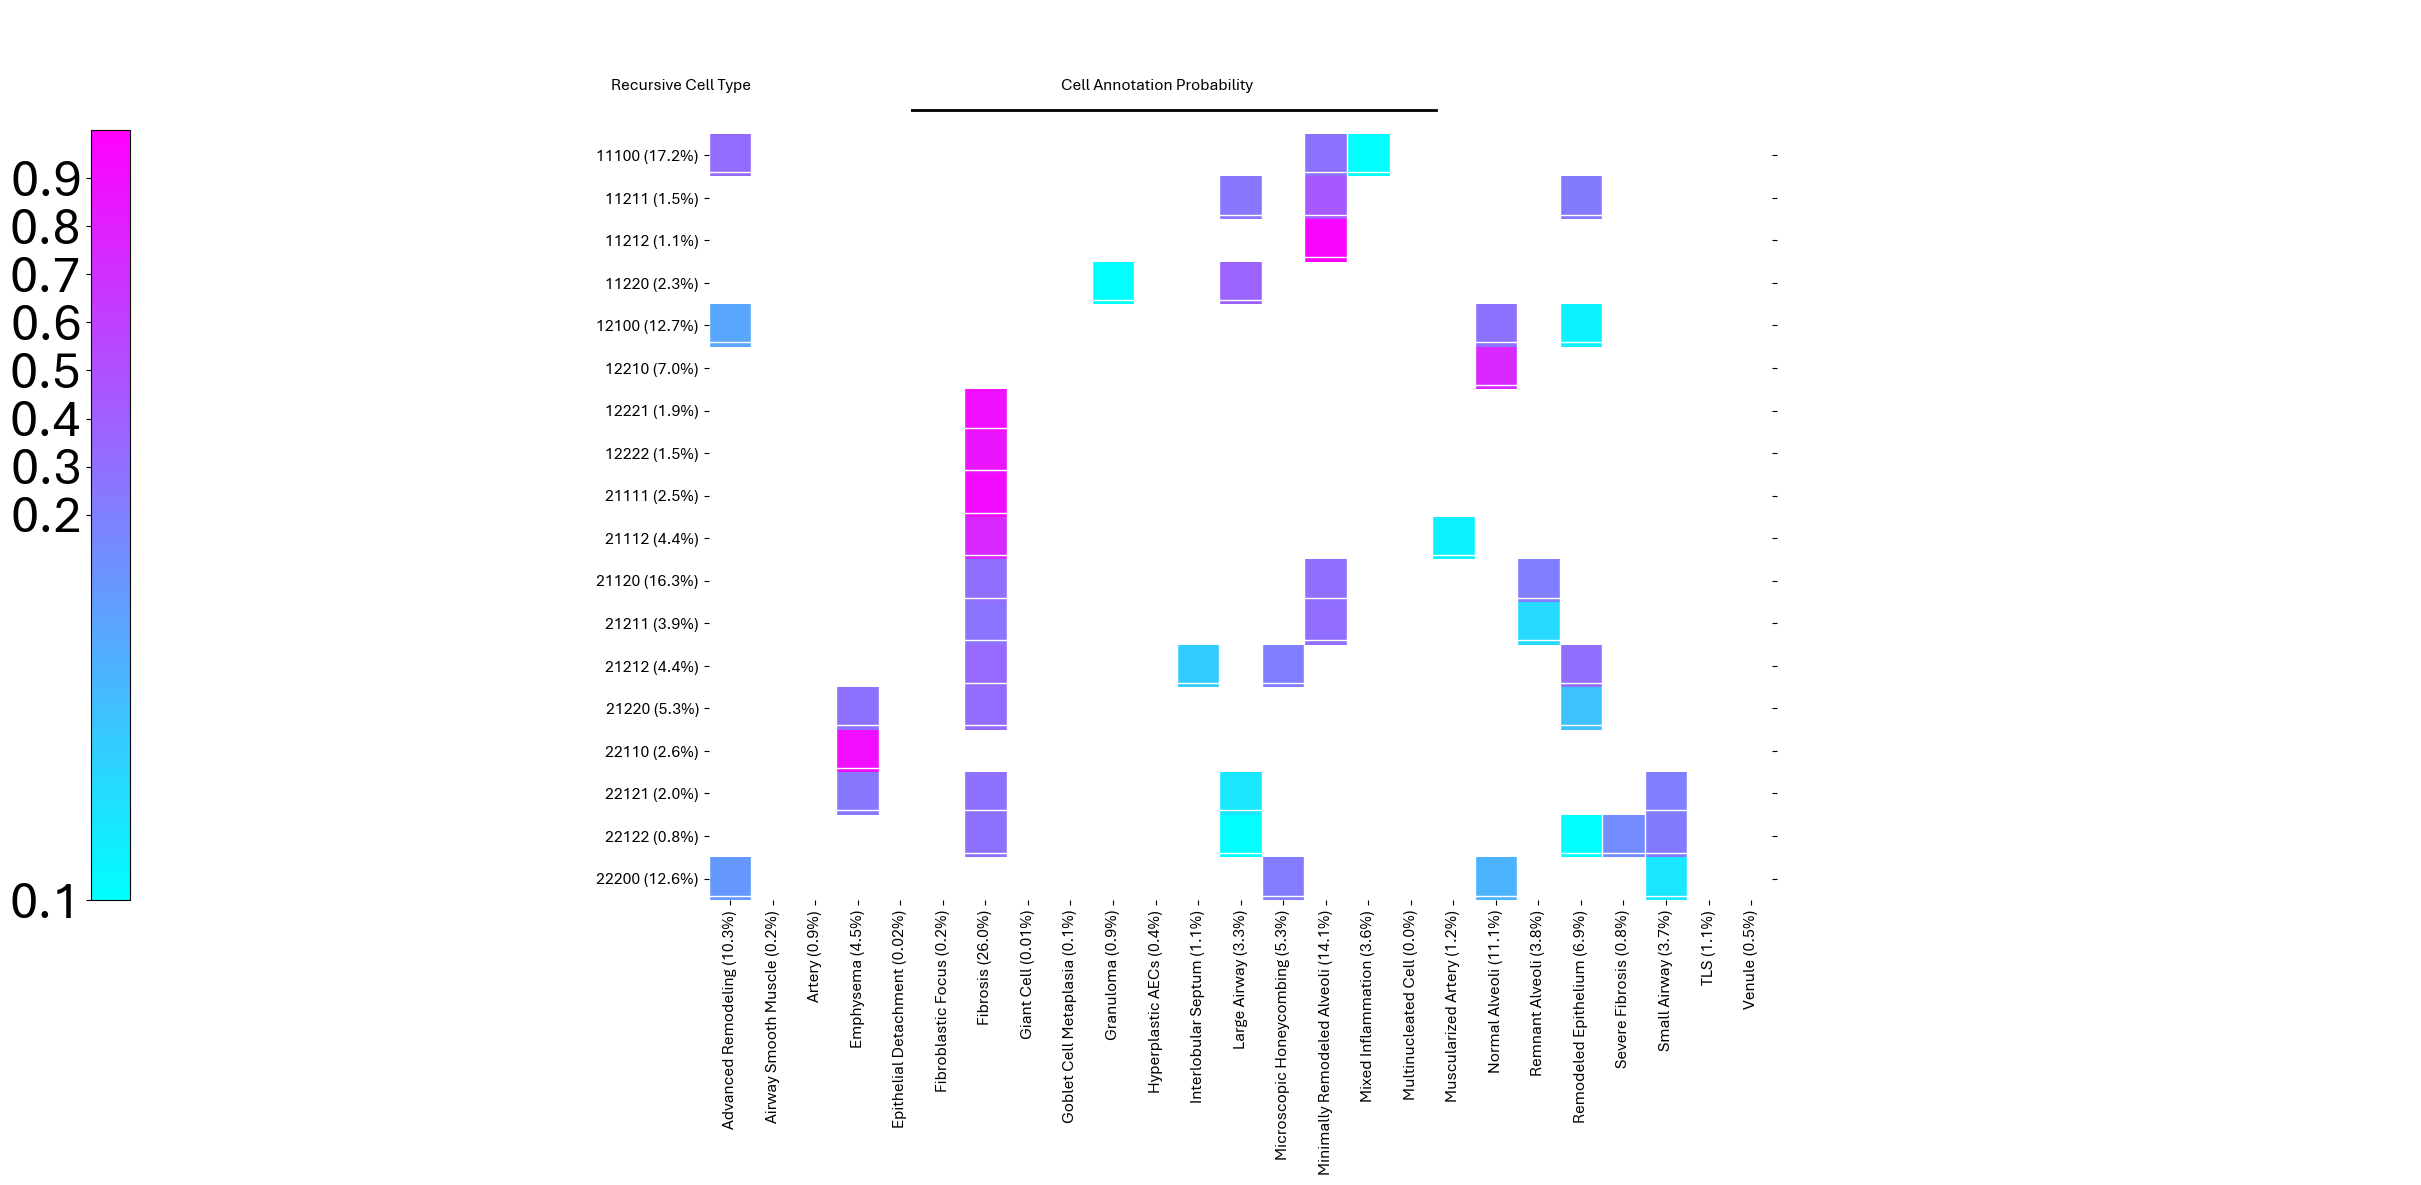

In [ ]:
divnorm = colors.TwoSlopeNorm(vcenter=0.2)
heatmap(prob_map_sig, 
        [re.sub("Level5_","",val) + f' ({perc}%)' for val, perc in zip(rctypes, rctypes_perc)], 
        prob_map.columns.tolist(), np.repeat('',prob_map.shape[1]),
        first_column_name='Recursive Cell Type',
        middle_column_name='Cell Annotation Probability', description_column='',
        cbar_range=[0.1,1],
        header_bound=[-0.9,0.35],
        title_pos={'first' : -0.2,'middle' : 0.1, 'description' : 0.8},
        cmap='cool', norm=divnorm, cbar_kw={'location' : 'left', 'pad' : -0.3}, fsize=12,
        save_path=os.path.join(pub_path,'Banovich_annot_likelihood_hmap.svg'))

In [ ]:
annotlike_banovich = pd.DataFrame(prob_map_sig, columns=prob_map.columns.tolist(),
                                index=[re.sub("Level5_","",val) for val in rctypes])

## Thomas Annotation Probabilities

In [ ]:
## Niche anotations for the unbiased cell types
vgeneDF_annot = pd.read_parquet('./Data/thomas_annotDF.parquet')

vgeneDF_phenoDF = pd.get_dummies(vgeneDF_annot['Niche_NMF']).astype(int) \
                    .rename(columns=lambda x : x + ' positive') \
                    .assign(img=vgeneDF_unb_ctypes.img, id=vgeneDF_unb_ctypes.id)

In [ ]:
warnings.filterwarnings('ignore')
prob_map = []
for bmp, bmp_name in zip([[re.sub(' positive','',val) + '+'] for val in vgeneDF_phenoDF.drop(columns=['img','id']).columns],
                         [re.sub(' positive','',val) for val in vgeneDF_phenoDF.drop(columns=['img','id']).columns]) : 
    #col_name = '+/'.join(bmp) + '+'
    bmp_df, col_name, totcells = celltype_prob(vgeneDF_unb_ctypes,
                                    vgeneDF_phenoDF, 
                                    bmp,
                                    pheno_name=bmp_name) 
    #raise(Exception(""))
    prob_map.append(bmp_df.filter(items=['likelihood']) \
                    .rename(columns={'likelihood' : col_name}))
rctypes1 = bmp_df.celltype.tolist()
rctypes_perc1 = [round(100*perc,1) if perc > 0.0005 else 0.05 for perc in bmp_df.celltype_prop]
prob_map = pd.concat(prob_map, axis=1)

likehmap0 = celltype_bootstrap_prob(comb_csv=vgeneDF_unb_ctypes \
                                .assign(Resp=lambda df : [1 if 'IPF' in img else 0 for img in df.img]),
                                predef_phenoDF=vgeneDF_phenoDF,
                                predef_pheno=[[re.sub(' positive','',val) + '+'] for val in vgeneDF_phenoDF.drop(columns=['img','id']).columns],
                                celltype_level='Level5',
                                nboot=100, nproc=20)

prob_map_sig1 = prob_map.to_numpy()
for idx1 in range(prob_map_sig1.shape[0]):
    for idx2 in range(prob_map_sig1.shape[1]):
        if np.isnan(prob_map_sig1[idx1,idx2]) :
            continue
        bdist = [likehmap0[ix].iloc[idx1,idx2] for ix in range(len(likehmap0))]
        prob = np.sum([prob_map_sig1[idx1,idx2] > val for val in bdist]) / len(bdist)
        if (prob < 0.2) or (prob_map_sig1[idx1,idx2] < 0.1) :
            prob_map_sig1[idx1,idx2] = np.nan

In [ ]:
divnorm = colors.TwoSlopeNorm(vcenter=0.2)
heatmap(prob_map_sig1, 
        [re.sub("Level5_","",val) + f' ({perc}%)' for val, perc in zip(rctypes1, rctypes_perc1)], 
        prob_map.columns.tolist(), np.repeat('',prob_map.shape[1]),
        first_column_name='Recursive Cell Type',
        middle_column_name='Spot Annotation Probability', description_column='',
        cbar_range=[0.1,1],
        header_bound=[-0.4,0.1],
        title_pos={'first' : -0.2,'middle' : 0, 'description' : 0.8},
        cmap='cool', norm=divnorm, cbar_kw={'location' : 'left', 'pad' : -0.3}, fsize=12,
        save_path=os.path.join(pub_path,'Thomas_annot_likelihood_hmap.svg'))

In [ ]:
annotlike_thomas = pd.DataFrame(prob_map_sig1, columns=prob_map.columns.tolist(),
                                index=[re.sub("Level5_","",val) for val in rctypes1])

# Differential Gene Signature in Unbiased Cell Types

In [3]:
def find_diff_genes(in_df,ctype,disease_pts,lqnt=0.2,uqnt=0.8, verbose=False) : 
    ctype_geneDF = in_df[lambda df : df[ctype] == 1] \
                    .assign(Resp=lambda df : [1 if img in disease_pts else 0 for img in df.img])
    if verbose : 
        print(ctype_geneDF.Resp.value_counts(normalize=True))
    ctype_geneDF1 = ctype_geneDF[lambda df : df.Resp == 1] \
                    .filter(regex='^(?:(?!Level).)*$') \
                    .drop(columns=['x','y','img','id','Resp','no_cells','cluster'])
    bkgd_df = ctype_geneDF[lambda df : df.Resp == 0] \
                    .filter(regex='^(?:(?!Level).)*$') \
                    .drop(columns=['x','y','img','id','Resp','no_cells','cluster'])
    diff_genes =[]
    diff_val = []
    if bkgd_df.shape[0] == 0 :
        return pd.DataFrame({'genes' : [], 'diff' : []})
    for g in ctype_geneDF1.columns :
        lthres = np.quantile(bkgd_df[g].to_numpy().flatten(),lqnt)
        uthres = np.quantile(bkgd_df[g].to_numpy().flatten(),uqnt)
        g_thres = np.quantile(ctype_geneDF1[g].to_numpy().flatten(),0.5)
        #g_uthres = np.quantile(ctype_geneDF1[g].to_numpy().flatten(),uqnt)
        if (g_thres > uthres) : 
            diff_genes.append(g)
            diff_val.append(abs(g_thres - uthres))
        elif (g_thres < lthres) :
            diff_genes.append(g)
            diff_val.append(abs(g_thres - lthres))
    outdf = pd.DataFrame({'genes' : diff_genes, 'diff' : diff_val}) \
            .sort_values(by='diff', ascending=False)
    return outdf

## Banovich Differential Genes

In [ ]:
# Differential genes for each unbiased cell type
geneExp_ild_pts = [re.sub("_.*","",val) for val in ild_pts]
gselect_banovich_ctypes = []
for ctype in geneExp_unb_ctypes.filter(regex='Level5').columns : 
    gselect = find_diff_genes(geneExp_unb_ctypes, ctype,geneExp_ild_pts, lqnt=0.3, uqnt=0.7).genes
    gselect_banovich_ctypes.append(gselect)


In [ ]:
# Frequency of differential genes across cell types
gselect_banovichDF = pd.Series(list(chain(*gselect_banovich_ctypes))).value_counts(ascending=True) \
                        .rename_axis('gene').reset_index(name='freq')

In [ ]:
# Distribution of differential genes for a particular unbiased cell type
ctype = 'Level5_22121'
pdf_final = []
gselect = find_diff_genes(geneExp_unb_ctypes, ctype,geneExp_ild_pts, lqnt=0.3, uqnt=0.7)
for g in gselect.iloc[0:10,:].genes : 
    ctype_geneDF = geneExp_unb_ctypes[lambda df : df[ctype] == 1] \
                        .assign(Resp=lambda df : [1 if img in geneExp_ild_pts else 0 for img in df.img])
    resp_dist = ctype_geneDF[lambda df : df.Resp == 1][g].tolist()
    nresp_dist = ctype_geneDF[lambda df : df.Resp == 0][g].tolist()
    ss = int(np.min([np.ceil(0.1*len(resp_dist)),np.ceil(0.1*len(nresp_dist))]))
    pdf = pd.DataFrame({'IPF' : random.sample(resp_dist,ss), 'Healthy' : random.sample(nresp_dist,ss)}).assign(gene=g)
    pdf_final.append(pdf)
pdf_final = pd.concat(pdf_final)

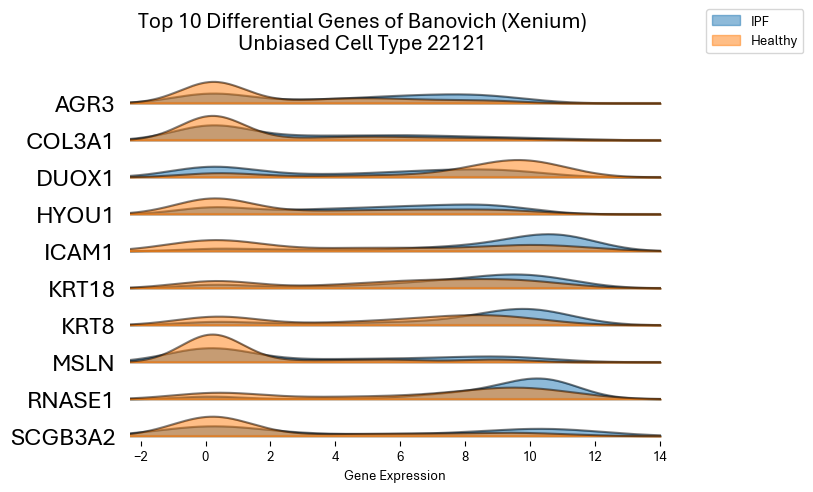

In [ ]:
fig, axes = joypy.joyplot(pdf_final, by='gene', overlap=0, alpha=0.5)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], bbox_to_anchor=(1.2, 1))
for ax in axes : 
    for tick in ax.get_yticklabels() :
        tick.set_fontweight("bold")
        tick.set_fontsize(18)
fig.subplots_adjust(top=0.85)
plt.suptitle(f"Top 10 Differential Genes of Banovich (Xenium)\nUnbiased Cell Type {re.sub('Level5_','',ctype)}",
             fontweight="bold", fontsize=16)
plt.xlabel("Gene Expression")
plt.savefig(os.path.join(pub_path,'unbiased_ctype_diffgenes_dist.svg'),format='svg',dpi=1200, bbox_inches='tight')
plt.show()

## Thomas Differential Genes

In [ ]:
# Differential genes for each unbiased cell type
vgene_ild_pts = [val for val in vgeneDF_unb_ctypes.img.unique() if 'IPF' in val]
gselect_thomas_ctypes = []
for ctype in vgeneDF_unb_ctypes.filter(regex='Level5').columns : 
    gselect = find_diff_genes(vgeneDF_unb_ctypes, ctype, vgene_ild_pts, lqnt=0.3, uqnt=0.7).genes
    gselect_thomas_ctypes.append(gselect)

In [ ]:
# Frequency of differential genes across cell types
gselect_thomasDF = pd.Series(list(chain(*gselect_thomas_ctypes))).value_counts(ascending=True) \
                        .rename_axis('gene').reset_index(name='freq')

# Gene Signature Overlap

In [ ]:
# Flag differential genes that meet the requirement as a gene signature
gthres = 6 # Differential gene must only appear in 6 or fewer unbiased cell types
diff_genes = sorted(list(set(gselect_banovichDF[lambda df : df['freq'] <= gthres].gene) \
                .intersection(gselect_thomasDF[lambda df : df['freq'] <= gthres].gene)))
diff_genes

['ACKR1',
 'AGR3',
 'ATF3',
 'ATG7',
 'ATP2A3',
 'BANK1',
 'BCL2',
 'BCL2L1',
 'BCL2L11',
 'BPIFA1',
 'C1QC',
 'C20orf85',
 'CCL18',
 'CCL21',
 'CCL5',
 'CD14',
 'CD1C',
 'CD34',
 'CD3E',
 'CD52',
 'CD79A',
 'CLDN5',
 'COL15A1',
 'CPA3',
 'CXCL13',
 'DCTPP1',
 'DERL3',
 'DMBT1',
 'EGFR',
 'EPCAM',
 'ERN2',
 'FABP4',
 'FCER1A',
 'FCER1G',
 'FCGR3A',
 'FCN3',
 'FGF10',
 'FGF2',
 'FGF7',
 'FOXJ1',
 'GZMA',
 'GZMB',
 'HAS1',
 'HIF1A',
 'HSPA5',
 'IL1A',
 'IL4R',
 'IL7R',
 'ISG20',
 'ITGA3',
 'ITGAX',
 'ITGB6',
 'KDR',
 'KIT',
 'KRT5',
 'LAMP3',
 'LCK',
 'LGR5',
 'LTF',
 'MAL',
 'MARCO',
 'MCEMP1',
 'MKI67',
 'MRC1',
 'MS4A1',
 'MUC5AC',
 'MUC5B',
 'NAPSA',
 'NKG7',
 'OAS2',
 'PDCD1',
 'PDIA3',
 'PGC',
 'PI16',
 'PIM2',
 'PLIN2',
 'PLVAP',
 'PTPRC',
 'RAMP2',
 'RHOA',
 'S100A2',
 'SCGB3A2',
 'SFRP2',
 'SFTA2',
 'SFTPD',
 'SLC1A3',
 'SLC25A37',
 'SLC25A4',
 'SLC2A1',
 'SLC7A11',
 'SNAI2',
 'SOD2',
 'SPP1',
 'STAT1',
 'TCL1A',
 'TOP2A',
 'TP63',
 'TP73',
 'TRAC',
 'TREM2',
 'UBE2J1',
 'WNT2',

In [ ]:
# Identifying the overlapping genes in Thomas unbiased cell types from the gene signature of a Banovich unbiased cell type
warnings.filterwarnings('ignore')
ctype = 'Level5_22121'
ix1 = [ix for ix, bctype in enumerate(geneExp_unb_ctypes.filter(regex='Level5').columns) if bctype == ctype][0]
gene1 = list(set(gselect_banovich_ctypes[ix1]).intersection(diff_genes))
ctype_genemap = pd.DataFrame(columns=diff_genes, 
                           index=[re.sub("Level[0-9]+_","",val) for val in vgeneDF_unb_ctypes.filter(regex='Level5').columns])
for ix2, tctype in enumerate([re.sub("Level[0-9]+_","",val) for val in vgeneDF_unb_ctypes.filter(regex='Level5').columns]) :
    gene2 = list(set(gselect_thomas_ctypes[ix2]).intersection(diff_genes)) 
    gene_hits = list(set(gene1).intersection(gene2))
    bgenes_only = list(set(gene1).difference(gene_hits))
    tgenes_only = list(set(gene2).difference(gene_hits))
    if len(gene_hits) != 0 :
        for g in gene_hits :
            ctype_genemap.loc[tctype,g] = 3
    if len(tgenes_only) != 0 :
        for g in tgenes_only : 
            ctype_genemap.loc[tctype,g] = 2
    if len(bgenes_only) != 0 :
        for g in bgenes_only :
            ctype_genemap.loc[tctype,g] = 1
ctype_genemap = ctype_genemap.fillna(np.nan)
## remove genes with no overlap between Banovich cell type and Thomas cell types
drop_genes = ctype_genemap.apply(lambda x : [True if 3 in x.tolist() else False]).transpose() \
                [lambda df : ~df[0]].index.tolist()
ctype_genemap = ctype_genemap.drop(columns=drop_genes)

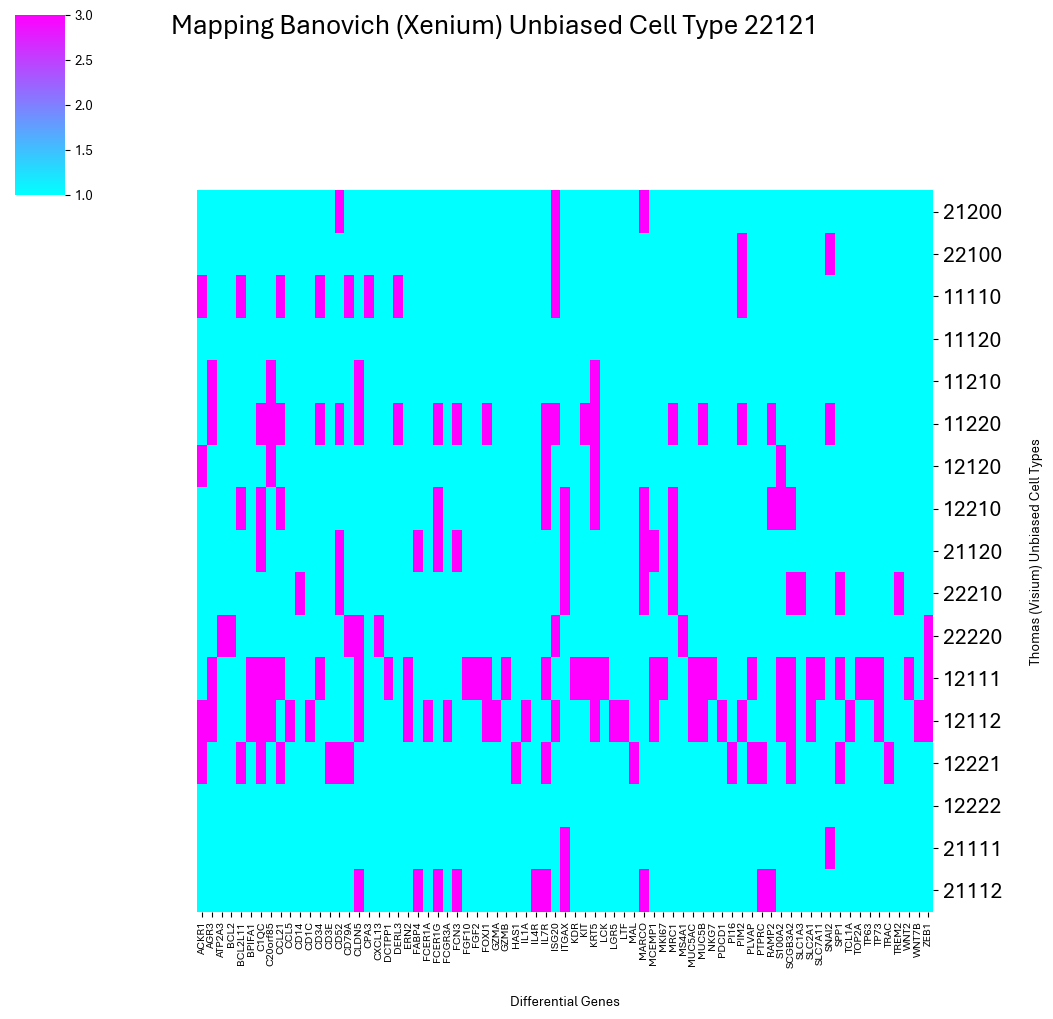

In [ ]:
ax3 = sns.clustermap(ctype_genemap, 
                     row_cluster=False, col_cluster=False, xticklabels=True,
                     yticklabels=True, cmap='cool')
ax3.fig.suptitle(f"Mapping Banovich (Xenium) Unbiased Cell Type {re.sub('Level5_','',ctype)}",
                 fontweight='bold', fontsize=20)
ax3.ax_heatmap.set_xticklabels(ax3.ax_heatmap.get_xmajorticklabels(),
                               fontsize=8,fontweight='bold',rotation=90)
ax3.ax_heatmap.set_yticklabels(ax3.ax_heatmap.get_ymajorticklabels(),
                               fontsize=16,fontweight='bold')
# plt.legend(handles,ctypesList, title='Unbiased Cell Types',bbox_to_anchor=(0,0),
#            bbox_transform=plt.gcf().transFigure, loc='lower left')
ax3.ax_heatmap.set_ylabel("Thomas (Visium) Unbiased Cell Types", labelpad=20)
ax3.ax_heatmap.set_xlabel("Differential Genes", labelpad=20)
plt.savefig(os.path.join(pub_path,'unbiased_ctype_mapping_diffgenes_hmap.svg'),format='svg',dpi=1200, bbox_inches='tight')
plt.show()

# Cross-dataset mapping of Unbiased Cell Types

In [ ]:
# Pair-wise computation of DICE score on gene signature overlap between unbiased cell types across datasets
ctype_mapDF = pd.DataFrame(columns=[re.sub("Level[0-9]+_","",val) for val in vgeneDF_unb_ctypes.filter(regex='Level5').columns], 
                           index=[re.sub("Level[0-9]+_","",val) for val in geneExp_unb_ctypes.filter(regex='Level5').columns])
for ix1, bctype in enumerate([re.sub("Level[0-9]+_","",val) for val in geneExp_unb_ctypes.filter(regex='Level5').columns]) : 
    for ix2, tctype in enumerate([re.sub("Level[0-9]+_","",val) for val in vgeneDF_unb_ctypes.filter(regex='Level5').columns]) :
        gene1 = gselect_banovich_ctypes[ix1]
        gene2 = gselect_thomas_ctypes[ix2]
        gene_hits = list(set(gene1).intersection(gene2))
        if len(gene_hits) == 0 :
            continue
        dscore = 2*len(gene_hits) / (len(gene1) + len(gene2))
        if dscore > 0.25 :
            for hgene in gene_hits :
                if hgene in diff_genes :
                    ctype_mapDF.loc[bctype,tctype] = dscore
ctype_mapDF = ctype_mapDF.fillna(np.nan)

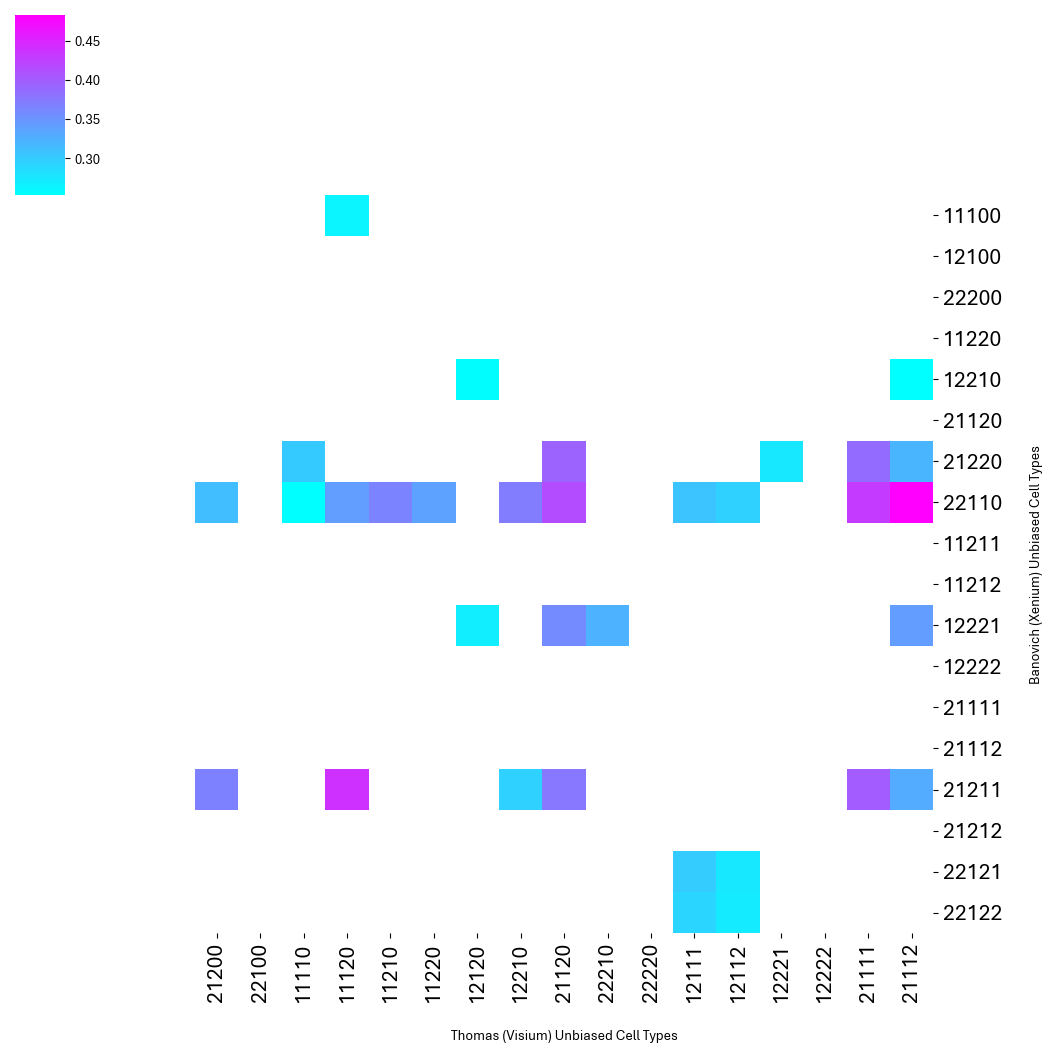

In [ ]:
ax3 = sns.clustermap(ctype_mapDF, 
                     row_cluster=False, col_cluster=False, xticklabels=True,
                     yticklabels=True, cmap='cool')
ax3.ax_heatmap.set_xticklabels(ax3.ax_heatmap.get_xmajorticklabels(),
                               fontsize=16,fontweight='bold',rotation=90)
ax3.ax_heatmap.set_yticklabels(ax3.ax_heatmap.get_ymajorticklabels(),
                               fontsize=16,fontweight='bold')
# plt.legend(handles,ctypesList, title='Unbiased Cell Types',bbox_to_anchor=(0,0),
#            bbox_transform=plt.gcf().transFigure, loc='lower left')
ax3.ax_heatmap.set_ylabel("Banovich (Xenium) Unbiased Cell Types", labelpad=20)
ax3.ax_heatmap.set_xlabel("Thomas (Visium) Unbiased Cell Types", labelpad=20)
plt.savefig(os.path.join(pub_path,'unbiased_ctype_mapped_hmap.svg'),format='svg',dpi=1200, bbox_inches='tight')
plt.show()

# Spatial Microdomain Discovery

In [ ]:
# Select mappable Banovich unbiased cell types
keep_bctypes = ['Level5_' + val for val in ctype_mapDF[lambda df : df.sum(axis=1) > 0 ].index]
rm_bctypes = list(set(geneExp_unb_ctypes.filter(regex='Level5').columns).difference(keep_bctypes))
print(f"{len(keep_bctypes)} cell types kept")

8 cell types kept


In [ ]:
# Select mappable Thomas unbiased cell types
keep_tctypes = ['Level5_' + val for val in ctype_mapDF.sum(axis=0).rename_axis('ctype').reset_index(name='hits') \
                [lambda df : df.hits > 0].ctype]
rm_tctypes = list(set(vgeneDF_unb_ctypes.filter(regex='Level5').columns).difference(keep_tctypes))

## Banovich microdomain inference

In [ ]:
warnings.filterwarnings('ignore')
for pval in [0.1] : 
    for lev in ['Level5'] : 
        microdomain_signif_df_banovich, pmiAllcellDF_banovich, comb_csv_copy_banovich, \
            resp_pmi_banovich, nresp_pmi_banovich, \
            count_PMI_banovich, patient_pmi_map_banovich = recursive_pmi(
                                                            comb_csv=geneExp_unb_ctypes.drop(columns=rm_bctypes),
                                                            resp_pts = geneExp_ild_pts,
                                                            select_level = lev, 
                                                            save_path = f'./Output/Banovich/PMI/pval_{pval}/{lev}',
                                                            pixel_dist=100,
                                                            weighted_pmi=None,
                                                            fixed_bkgd=False,
                                                            p_signif=pval) 

start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for GSM7990532
start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for GSM7990533
start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for GSM7990534
start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for GSM7990535
start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for GSM7990536
start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for GSM7990537
start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for GSM7990539
start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for GSM

In [ ]:
# Non-self spatial interactions
udomain_banovich = microdomain_signif_df_banovich[lambda df : [True if len(set(val.split(":"))) != 1 else False for val in df.pmi]]
# self spatial interactions
udomain_banovich_self = microdomain_signif_df_banovich[lambda df : [False if len(set(val.split(":"))) != 1 else True for val in df.pmi]]

## Thomas microdomain inference

In [ ]:
warnings.filterwarnings('ignore')
for pval in [0.3] : 
    for lev in ['Level5'] : 
        microdomain_signif_df_thomas, pmiAllcellDF_thomas, comb_csv_copy_thomas, \
            resp_pmi_thomas, nresp_pmi_thomas, \
            count_PMI_thomas, patient_pmi_map_thomas = recursive_pmi(
                                                            comb_csv=vgeneDF_unb_ctypes.drop(columns=rm_tctypes),
                                                            resp_pts = vgene_ild_pts,
                                                            select_level = lev, 
                                                            save_path = f'./Output/Thomas/PMI/pval_{pval}/{lev}',
                                                            pixel_dist=100,
                                                            weighted_pmi=None,
                                                            fixed_bkgd=False,
                                                            p_signif=pval) 
        

start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for Donor_Control_1
start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for Donor_Control_2
start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for Donor_Control_3
start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for Donor_Control_4
start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for Donor_IPF_1
start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for Donor_IPF_2
start the pooling of inputs for PMI computation
start pmi compute
parallel PMI compute complete.
PMI completed for Donor_IPF_3


In [ ]:
# Non-self spatial interactions
udomain_thomas = microdomain_signif_df_thomas[lambda df : [True if len(set(val.split(":"))) != 1 else False for val in df.pmi]]
# self spatial interactions
udomain_thomas_self = microdomain_signif_df_thomas[lambda df : [False if len(set(val.split(":"))) != 1 else True for val in df.pmi]]

# Cross-dataset mapping of Spatial Microdomains

In [ ]:
# Banovich and Thomas spatial interactions of microdomains
udomain_ctype_banovich = list(chain(*[val.split(":") for val in udomain_banovich.pmi]))
udomain_ctype_banovich = [val for val in pd.unique(udomain_ctype_banovich)]
udomain_ctype_thomas = list(chain(*[val.split(":") for val in udomain_thomas.pmi]))
udomain_ctype_thomas = [val for val in pd.unique(udomain_ctype_thomas)]

In [ ]:
# Unbiased cell type mapping between Banovich and Thomas data based on the cell types from spatial interactions
bcellmapList = []
tcellmapList = []
for bcell in udomain_ctype_banovich : 
    cmapDF = ctype_mapDF.loc[bcell].rename_axis('ctype').reset_index(name='score') \
            [lambda df : ~df['score'].isna()]
    if cmapDF.shape[0] == 0 :
        continue
    elif cmapDF.shape[0] == 1 :
        if cmapDF.ctype.tolist()[0] in udomain_ctype_thomas :
            bcellmapList.append(bcell)
            tcellmapList.append([cmapDF.ctype.tolist()[0]])
    else :
        tc = list(set(cmapDF.ctype.tolist()).intersection(udomain_ctype_thomas))
        if len(tc) != 0 : 
            #tc = cmapDF[lambda df : df.ctype.isin(tc)]
            #tc = tc[lambda df : df['score'] == np.max(df['score'])].ctype.tolist()[0]
            bcellmapList.append(bcell)
            tcellmapList.append(tc)

In [24]:
bcellmapList

['22110', '12210', '21211', '21220', '22122', '12221', '22121']

In [26]:
tcellmapList

[['11220',
  '12112',
  '12210',
  '11110',
  '21200',
  '21120',
  '11210',
  '21111',
  '12111'],
 ['12120'],
 ['12210', '21120', '21111', '21200'],
 ['21111', '21120', '12221', '11110'],
 ['12112', '12111'],
 ['22210', '21120', '12120'],
 ['12112', '12111']]

In [ ]:
## Unique mapping of spatial interactions between Banovich and Thomas data
bpmiList = []
tpmiList = []
for pmi in udomain_banovich.pmi :
    pmi1 = pmi.split(":")[0]
    pmi2 = pmi.split(":")[1]
    ix1 = [ix for ix, val in enumerate(bcellmapList) if val == pmi1]
    ix2 = [ix for ix, val in enumerate(bcellmapList) if val == pmi2]
    if (len(ix1) != 0) and (len(ix2) != 0) : 
        pmiList = []
        for pmi_ix1 in tcellmapList[ix1[0]] :
            for pmi_ix2 in tcellmapList[ix2[0]] : 
                pmiList.append(pmi_ix1 + ':' + pmi_ix2)
                pmiList.append(pmi_ix2 + ':' + pmi_ix1)
        pmi_mapped = list(set(udomain_thomas.pmi).intersection(pmiList))
        if len(pmi_mapped) != 0 :
            bpmiList.append(pmi)
            if len(pmi_mapped) > 1 : 
                pmi_subset = udomain_thomas[lambda df : ~df.pmi.isin(tpmiList)]
                pmi_mapped = pmi_subset[lambda df : df.pmi.isin(pmi_mapped)]
                pmi_mapped = pmi_mapped[lambda df : df.signif == np.max(df.signif)].pmi.tolist()
                tpmiList.append(pmi_mapped[0])
            else : 
                tpmiList.append(pmi_mapped[0])


In [28]:
bpmiList

['12210:22110',
 '12210:21211',
 '21220:22122',
 '22110:12221',
 '22110:22121',
 '21211:22121']

In [29]:
tpmiList

['11110:12120',
 '21200:12120',
 '11110:12111',
 '11110:21120',
 '11210:12111',
 '21120:12111']

In [ ]:
# Banovich microdomain network
bplotnames = list(set(list(chain(*[val.split(":") for val in bpmiList]))))
bplotdf = pd.DataFrame(columns=bplotnames, index=bplotnames)
for ix, pmi in enumerate(bpmiList) :
    pmi1 = pmi.split(":")[0]
    pmi2 = pmi.split(":")[1]
    bplotdf.loc[pmi1,pmi2] =  ix + 1
    bplotdf.loc[pmi2,pmi1] =  ix + 1

In [ ]:
# Thomas microdomain network
tplotnames = list(set(list(chain(*[val.split(":") for val in tpmiList]))))
tplotdf = pd.DataFrame(columns=tplotnames, index=tplotnames)
for ix, pmi in enumerate(tpmiList) :
    pmi1 = pmi.split(":")[0]
    pmi2 = pmi.split(":")[1]
    tplotdf.loc[pmi1,pmi2] =  ix + 1
    tplotdf.loc[pmi2,pmi1] =  ix + 1

In [ ]:
# Arrange the node colors representing the unbiased cell type mapping in microdomain networks
mapDFall = []
for bpmi, tpmi in zip(bpmiList,tpmiList) :
    bpmi1 = bpmi.split(":")[0]
    bpmi2 = bpmi.split(":")[1]
    tpmi1 = tpmi.split(":")[0]
    tpmi2 = tpmi.split(":")[1]
    mpdf1 = ctype_mapDF.loc[bpmi1].rename_axis('ttype').reset_index(name='score') \
            [lambda df : df.ttype.isin([tpmi1,tpmi2]) & (~df['score'].isna())] \
            .sort_values(by='score', ascending=False)
    mpdf2 = ctype_mapDF.loc[bpmi2].rename_axis('ttype').reset_index(name='score') \
            [lambda df : df.ttype.isin([tpmi1,tpmi2]) & (~df['score'].isna())] \
            .sort_values(by='score', ascending=False)
    # Banovich and Thomas cell types map uniquely
    if mpdf1.ttype.tolist()[0] != mpdf2.ttype.tolist()[0] : 
        mapDFall.append(pd.DataFrame({'bctype' : [bpmi1,bpmi2], 
                                     'tctype' : [mpdf1.ttype.tolist()[0],mpdf2.ttype.tolist()[0]]}))
    # Banovich cell type uniquely mapped to one Thomas cell type
    elif mpdf1.shape[0] == 1 :
        mapDFall.append(pd.DataFrame({'bctype' : [bpmi1,bpmi2], 
                                     'tctype' : [mpdf1.ttype.tolist()[0],mpdf2.ttype.tolist()[1]]}))
    # Banovich cell type uniquely mapped to one Thomas cell type
    elif mpdf2.shape[0] == 1 :
        mapDFall.append(pd.DataFrame({'bctype' : [bpmi1,bpmi2], 
                                     'tctype' : [mpdf1.ttype.tolist()[1],mpdf2.ttype.tolist()[0]]}))
    else : 
        ## both mpdf1 and mpdf2 have two tctypes with same score ranking...need to assign highest rank tctype
        raise(Exception(""))
mapDFall = pd.concat(mapDFall).reset_index(drop=True).drop_duplicates()

# Banovich cell types of spatial interactions mapping to multiple Thomas cell types
nonmappable_bctype = mapDFall.groupby('bctype').size() \
                        .rename_axis().reset_index(name='no') \
                        [lambda df : df['no'] > 1].bctype.tolist()

color_map = pd.DataFrame({'ttype' : list(set(mapDFall.tctype)),
                           'color' : ["#994F00","#006CD1","#40B0A6","#4B0092",'#FF0000','#FFC0CB']})
bplotname_colors = [color_map[lambda df : df.ttype == mapDFall[lambda df1 : df1.bctype == cc].tctype.tolist()[0]].color.tolist()[0] 
                    if cc not in nonmappable_bctype else "#000000"
                    for cc in bplotnames]
tplotname_colors = [color_map[lambda df : df.ttype == cc].color.tolist()[0] for cc in tplotnames]

bcolormap = {}
for bctype, bcolor in zip(bplotnames, bplotname_colors) :
    bcolormap.update({bctype : bcolor})

tcolormap = {}
for tctype, tcolor in zip(tplotnames, tplotname_colors) :
    tcolormap.update({tctype : tcolor})

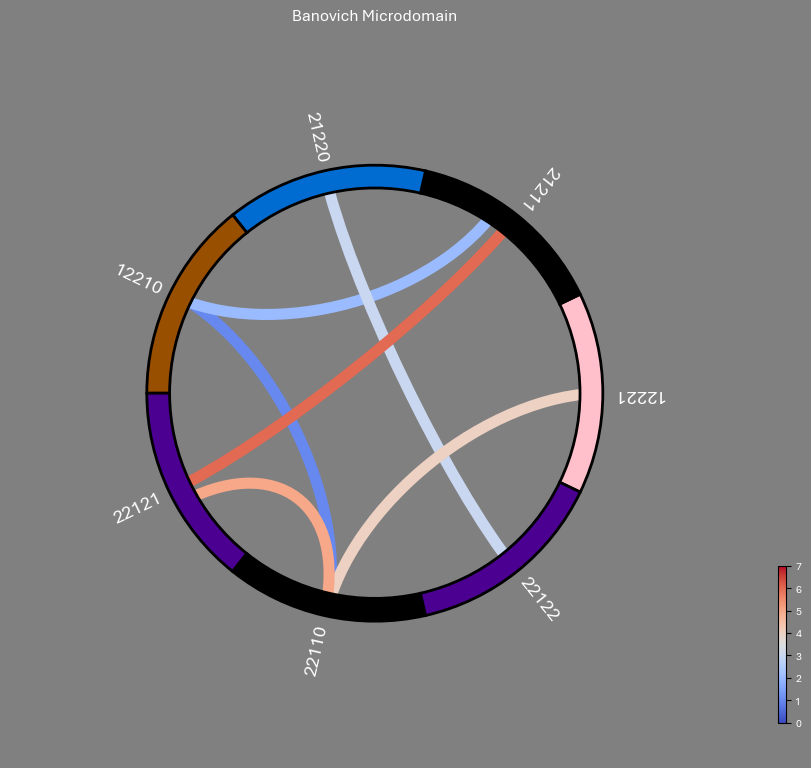

In [ ]:
fig, axes = plot_connectivity_circle(bplotdf.to_numpy(), bplotnames,
                                    vmin=0, vmax=7,
                                    colormap='coolwarm',
                                    facecolor='gray',
                                    node_colors=bplotname_colors,
                                    textcolor='white',
                                    colorbar=True,
                                    linewidth=8,
                                    fontsize_names=14,
                                    interactive=False,
                                    show=False,
                                    title='Banovich Microdomain'
                                    )
plt.savefig(os.path.join(pub_path,'Banovich_uDomain.svg'),format='svg',dpi=1200)

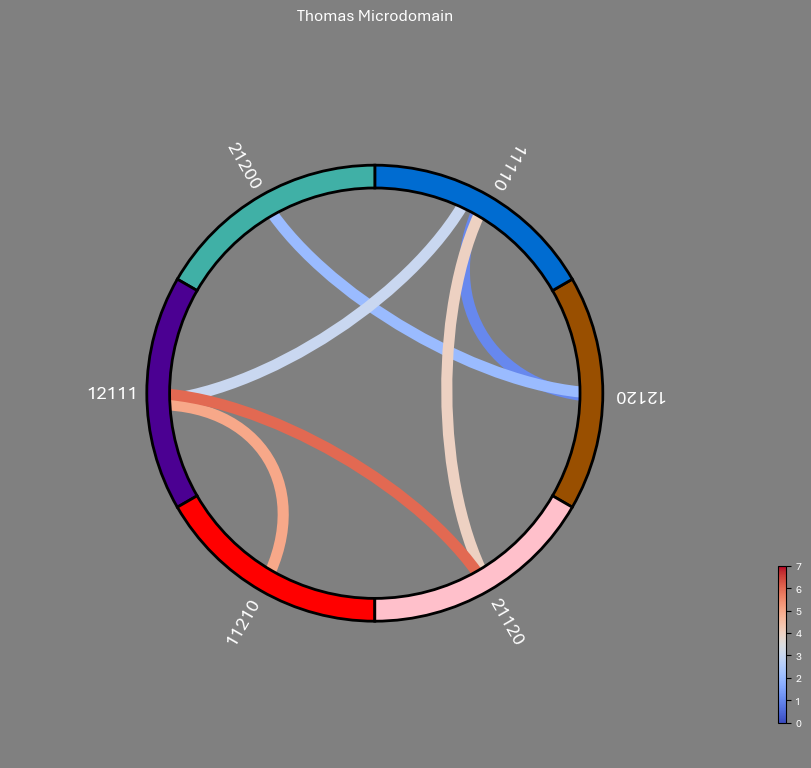

In [ ]:
fig, axes = plot_connectivity_circle(tplotdf.to_numpy(), tplotnames,
                                    vmin=0, vmax=7,
                                    colormap='coolwarm',
                                    facecolor='gray',
                                    node_colors=tplotname_colors,
                                    textcolor='white',
                                    colorbar=True,
                                    linewidth=8,
                                    fontsize_names=14,
                                    interactive=False,
                                    show=False,
                                    title='Thomas Microdomain'
                                    )
plt.savefig(os.path.join(pub_path,'Thomas_uDomain.svg'),format='svg',dpi=1200)

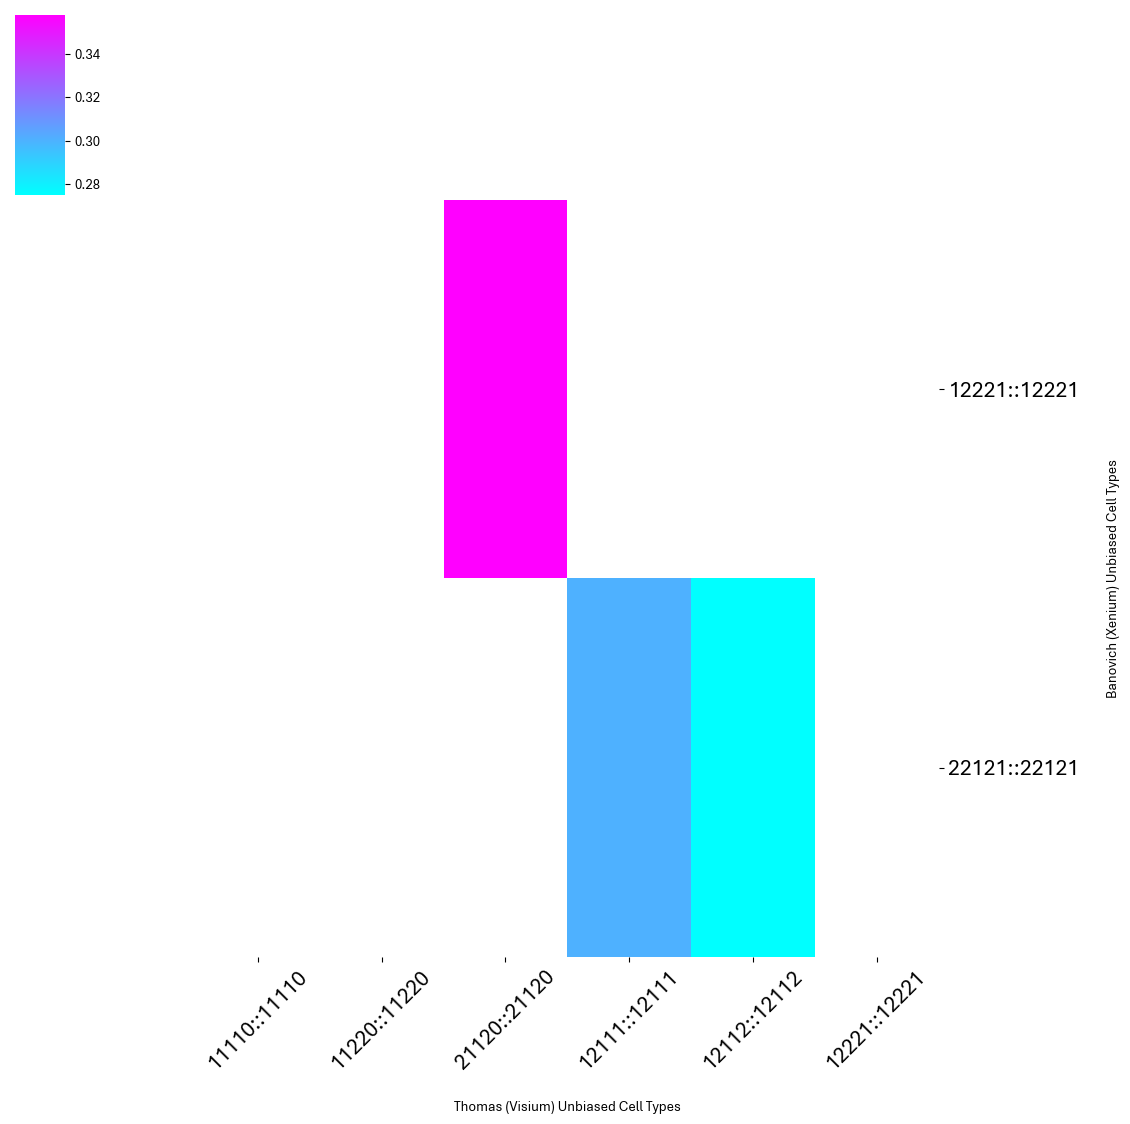

In [ ]:
# Mapping of self spatial interactions between Banovich and Thomas data
ax3 = sns.clustermap(ctype_mapDF.loc[[val.split(":")[0] for val in udomain_banovich_self.pmi]] \
                    .filter(items=[val.split(":")[0] for val in udomain_thomas_self.pmi]) \
                    .rename(columns=lambda x : x + '::' + x) \
                    .reset_index() \
                    .assign(**{'index' : lambda df : [val + '::' + val for val in df['index']]}) \
                    .set_index('index'), 
                     row_cluster=False, col_cluster=False, xticklabels=True,
                     yticklabels=True, cmap='cool')
ax3.ax_heatmap.set_xticklabels(ax3.ax_heatmap.get_xmajorticklabels(),
                               fontsize=16,fontweight='bold',rotation=45)
ax3.ax_heatmap.set_yticklabels(ax3.ax_heatmap.get_ymajorticklabels(),
                               fontsize=16,fontweight='bold', rotation=0)
# plt.legend(handles,ctypesList, title='Unbiased Cell Types',bbox_to_anchor=(0,0),
#            bbox_transform=plt.gcf().transFigure, loc='lower left')
ax3.ax_heatmap.set_ylabel("Banovich (Xenium) Unbiased Cell Types", labelpad=20)
ax3.ax_heatmap.set_xlabel("Thomas (Visium) Unbiased Cell Types", labelpad=20)
plt.savefig(os.path.join(pub_path,'uDomain_self_hmap.svg'),format='svg',dpi=1200, bbox_inches='tight')
plt.show()

# Cross-dataset spatial microdomain annotations comparison

In [245]:
bannotDF = []
tannotDF = []
for bpmi, tpmi in zip(bpmiList,tpmiList) : 
    bpmi1 = bpmi.split(":")[0]
    bpmi2 = bpmi.split(":")[1]
    tpmi1 = tpmi.split(":")[0]
    tpmi2 = tpmi.split(":")[1]

    bannot1 = annotlike_banovich.loc[bpmi1].rename_axis('annot').reset_index(name='prob') \
                [lambda df : ~df.prob.isna()]
    bannot2 = annotlike_banovich.loc[bpmi2].rename_axis('annot').reset_index(name='prob') \
                [lambda df : ~df.prob.isna()]
    bannot = pd.concat([bannot1,bannot2]).reset_index(drop=True) \
                .groupby('annot') \
                .agg({'prob' : lambda x : math.prod(x)}) \
                .reset_index() \
                .assign(pmi=re.sub(":","::",bpmi))
    bannotDF.append(bannot.pivot(index='pmi',columns='annot',values='prob'))

    tannot1 = annotlike_thomas.loc[tpmi1].rename_axis('annot').reset_index(name='prob') \
                [lambda df : ~df.prob.isna()]
    tannot2 = annotlike_thomas.loc[tpmi2].rename_axis('annot').reset_index(name='prob') \
                [lambda df : ~df.prob.isna()]
    tannot = pd.concat([tannot1,tannot2]).reset_index(drop=True) \
                .groupby('annot') \
                .agg({'prob' : lambda x : math.prod(x)}) \
                .reset_index() \
                .assign(pmi=re.sub(":","::",tpmi))
    tannotDF.append(tannot.pivot(index='pmi',columns='annot',values='prob'))
bannotDF = pd.concat(bannotDF) \
            .rename(columns=lambda x : re.sub("\s\\(.*$","",x))
tannotDF = pd.concat(tannotDF) \
            .rename(columns=lambda x : re.sub("\s\\(.*$","",x))

In [246]:
bannotDF

annot,Emphysema,Normal Alveoli,Fibrosis,Minimally Remodeled Alveoli,Remnant Alveoli,Large Airway,Remodeled Epithelium,Severe Fibrosis,Small Airway
pmi,,,,,,,,,
12210::22110,0.9100,0.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12210::21211,NaN,0.75,0.2700,0.31,0.13,NaN,NaN,NaN,NaN
21220::22122,0.2900,NaN,0.0957,NaN,NaN,0.10,0.015,0.19,0.23
22110::12221,0.9100,NaN,0.9000,NaN,NaN,NaN,NaN,NaN,NaN
22110::22121,0.2275,NaN,0.2900,NaN,NaN,0.12,NaN,NaN,0.20
21211::22121,0.2500,NaN,0.0783,0.31,0.13,0.12,NaN,NaN,0.20


In [247]:
tannotDF

annot,Alveolar,Fibroblast,SMCs_Adv_Meso,Airway,Fibrotic,Immune
pmi,,,,,,
11110::12120,0.700,0.0322,0.2900,NaN,NaN,NaN
21200::12120,NaN,0.0276,0.0435,0.18,0.13,0.270
11110::12111,0.700,0.0364,0.2800,NaN,NaN,0.100
11110::21120,0.392,0.1400,NaN,NaN,NaN,0.120
11210::12111,0.550,0.2600,0.0476,NaN,NaN,0.100
21120::12111,0.560,0.2600,0.2800,NaN,NaN,0.012


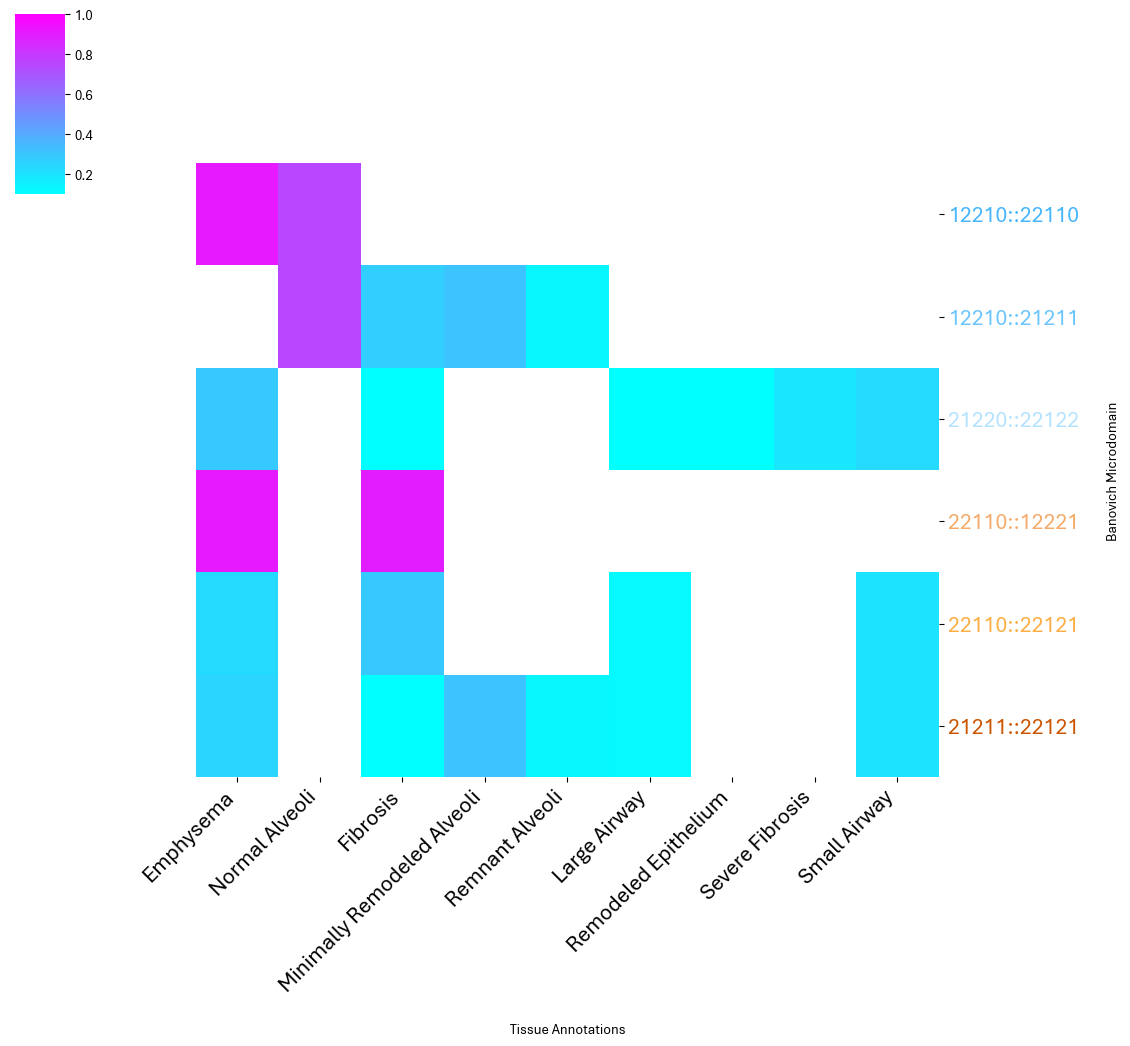

In [ ]:
ax3 = sns.clustermap(bannotDF, 
                     row_cluster=False, col_cluster=False, xticklabels=True,
                     yticklabels=True, cmap='cool', vmin=0.1, vmax=1)
ax3.ax_heatmap.set_xticklabels(ax3.ax_heatmap.get_xmajorticklabels(),
                               fontsize=16,fontweight='bold',rotation=45,
                               ha='right')
ax3.ax_heatmap.set_yticklabels(ax3.ax_heatmap.get_ymajorticklabels(),
                               fontsize=16,fontweight='bold', rotation=0)
# plt.legend(handles,ctypesList, title='Unbiased Cell Types',bbox_to_anchor=(0,0),
#            bbox_transform=plt.gcf().transFigure, loc='lower left')
ax3.ax_heatmap.set_ylabel("Banovich Microdomain", labelpad=20)
ax3.ax_heatmap.set_xlabel("Tissue Annotations", labelpad=20)
labcolor = ["#45b6fe","#6ac5fe","#b5e2ff","#f4ab6a","#fdae44","#cc5500"]
for ticklabel, labelcolor in zip(ax3.ax_heatmap.get_yticklabels(), labcolor) :
    ticklabel.set_color(labelcolor)
plt.savefig(os.path.join(pub_path,'Banovich_uDomain_annot.svg'),format='svg',dpi=1200, bbox_inches='tight')
plt.show()

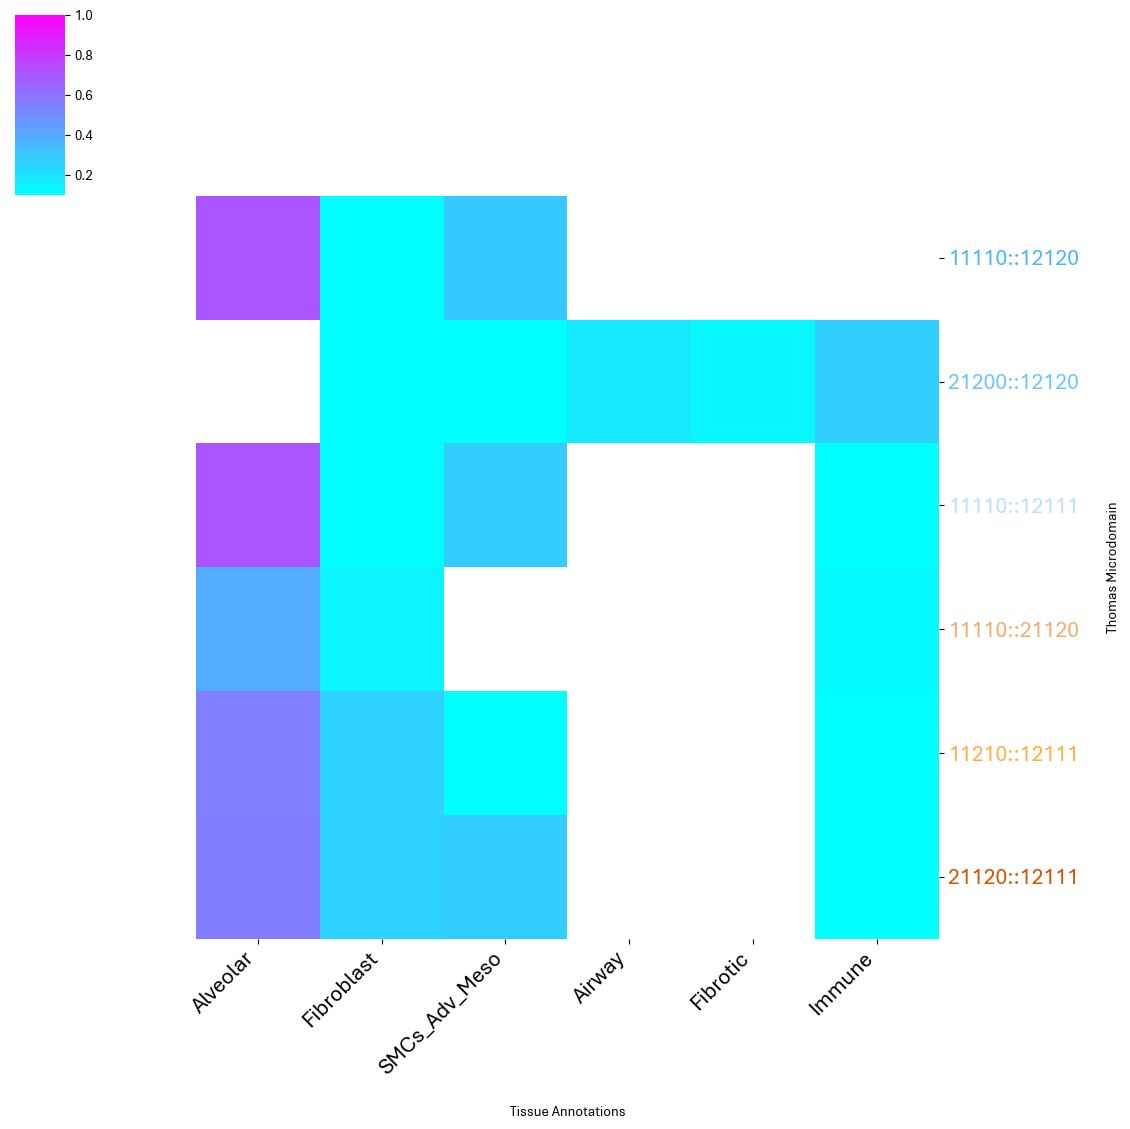

In [ ]:
ax3 = sns.clustermap(tannotDF, 
                     row_cluster=False, col_cluster=False, xticklabels=True,
                     yticklabels=True, cmap='cool', vmin=0.1, vmax=1)
ax3.ax_heatmap.set_xticklabels(ax3.ax_heatmap.get_xmajorticklabels(),
                               fontsize=16,fontweight='bold',rotation=45,
                               ha='right')
ax3.ax_heatmap.set_yticklabels(ax3.ax_heatmap.get_ymajorticklabels(),
                               fontsize=16,fontweight='bold', rotation=0)
# plt.legend(handles,ctypesList, title='Unbiased Cell Types',bbox_to_anchor=(0,0),
#            bbox_transform=plt.gcf().transFigure, loc='lower left')
ax3.ax_heatmap.set_ylabel("Thomas Microdomain", labelpad=20)
ax3.ax_heatmap.set_xlabel("Tissue Annotations", labelpad=20)
labcolor = ["#45b6fe","#6ac5fe","#b5e2ff","#f4ab6a","#fdae44","#cc5500"]
for ticklabel, labelcolor in zip(ax3.ax_heatmap.get_yticklabels(), labcolor) :
    ticklabel.set_color(labelcolor)
plt.savefig(os.path.join(pub_path,'Thomas_uDomain_annot.svg'),format='svg',dpi=1200, bbox_inches='tight')
plt.show()

# Visiualization of Spatial Microdomains in IPF patient tissue samples

In [ ]:
# Spatial coordinates of cells (Banovich) or spots (Thomas) including cells that belong to spatial microdomains
select_pmiDF_banovich = []
for pmi in bpmiList : 
    pmi1 = pmi.split(":")[0]
    pmi2 = pmi.split(":")[1]
    for pmi_col in pmiAllcellDF_banovich.filter(regex='Level5').columns :
        if (pmi1 in pmi_col) and (pmi2 in pmi_col) :
            pmi_color = bcolormap[re.sub("Level5_","",pmi_col.split(":")[0])]
            select_pmiDF_banovich.append(pmiAllcellDF_banovich[lambda df : df[pmi_col] > 0] \
                                .filter(items=['x','y','img']) \
                                .assign(color=pmi_color))
select_pmiDF_banovich = pd.concat(select_pmiDF_banovich).reset_index(drop=True).drop_duplicates()

select_pmiDF_thomas = []
for pmi in tpmiList : 
    pmi1 = pmi.split(":")[0]
    pmi2 = pmi.split(":")[1]
    for pmi_col in pmiAllcellDF_thomas.filter(regex='Level5').columns :
        if (pmi1 in pmi_col) and (pmi2 in pmi_col) :
            pmi_color = tcolormap[re.sub("Level5_","",pmi_col.split(":")[0])]
            select_pmiDF_thomas.append(pmiAllcellDF_thomas[lambda df : df[pmi_col] > 0] \
                                .filter(items=['x','y','img']) \
                                .assign(color=pmi_color))
select_pmiDF_thomas = pd.concat(select_pmiDF_thomas).reset_index(drop=True).drop_duplicates()

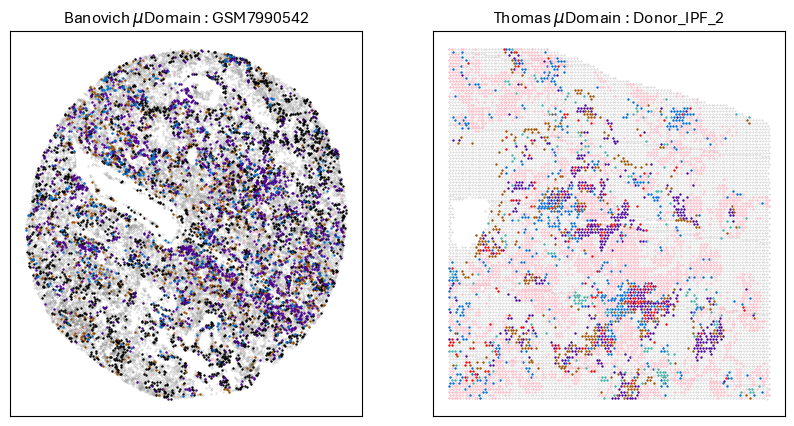

In [ ]:
ild_pt1 = 'GSM7990542' # Banovich IPF patient
ild_pt2 = 'Donor_IPF_2' # Thomas IPF patient
img_pt1 = pmiAllcellDF_banovich[lambda df : df.img == ild_pt1]
img_pt2 = pmiAllcellDF_thomas[lambda df : df.img == ild_pt2]
img_pt2 = img_pt2[lambda df : (df.x < 3000) & (df.y < 3000)]
udomain_pt1 = select_pmiDF_banovich[lambda df : df.img == ild_pt1]
udomain_pt2 = select_pmiDF_thomas[lambda df : df.img == ild_pt2]
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(img_pt1.x,img_pt1.y, s=0.1, alpha=0.5, color='gray')
for pcolor in udomain_pt1.color.unique() : 
    udomain_ctype1 = udomain_pt1[lambda df : df['color'] == pcolor]
    plt.scatter(udomain_ctype1.x, udomain_ctype1.y, s=0.5, color=pcolor)
ax1.set_title(rf"Banovich $\mu$Domain : {ild_pt1}")
plt.xticks([])
plt.yticks([])

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(img_pt2.x,img_pt2.y, s=0.1, alpha=0.5, color='gray')
for pcolor in udomain_pt2.color.unique() : 
    udomain_ctype2 = udomain_pt2[lambda df : df['color'] == pcolor]
    plt.scatter(udomain_ctype2.x, udomain_ctype2.y, s=0.5, color=pcolor)
ax2.set_title(rf"Thomas $\mu$Domain : {ild_pt2}")
plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(pub_path,'uDomain_mapped_image.svg'),format='svg',dpi=1200)